In [8]:
# Import libraries
import pandas as pd
# xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# scores
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
# kfold
from sklearn.model_selection import KFold
# gridsearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# matplotlib
import matplotlib.pyplot as plt
# datetime
import datetime as dt
# numpy
import numpy as np
import sys
sys.path.insert(1, '../utils/')
from data_visualization import residuals_hist, residuals_scatter
from preprocessing import preprocess_cosumo 
import pickle


In [9]:
# load train data
df = pd.read_excel('../data/consumo_material_clean.xlsx', parse_dates=['FECHAPEDIDO'])
df_train = pd.read_csv('../data/consumo_no23.csv')
df_test = pd.read_csv('../data/consumo_23.csv')

# Process data and sperate between train and test
df = preprocess_cosumo(df)
df_train = df[df['FECHAPEDIDO']<dt.datetime(year=2023,month=1,day=1)]
df_test = df[df['FECHAPEDIDO']>=dt.datetime(year=2023,month=1,day=1)]

KeyboardInterrupt: 

In [ ]:
# Drop the date columns
df_train.drop(columns=['FECHAPEDIDO'], inplace=True)
df_test.drop(columns=['FECHAPEDIDO'], inplace=True)

C:\Users\berna\AppData\Local\Temp\ipykernel_6544\545457921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['FECHAPEDIDO'], inplace=True)
C:\Users\berna\AppData\Local\Temp\ipykernel_6544\545457921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['FECHAPEDIDO'], inplace=True)


In [ ]:
df_train.head()

,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,STACKS_COMPRATS,CODIGO_B40558,CODIGO_B41691,CODIGO_C26183,CODIGO_C56207,CODIGO_E64488,...,DEPARTMENT_90,DEPARTMENT_91,DEPARTMENT_92,DEPARTMENT_93,DEPARTMENT_94,DEPARTMENT_95,DEPARTMENT_96,DEPARTMENT_97,DEPARTMENT_98,DEPARTMENT_99
1,40,10,102.803729,411.214916,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20,5,12.100000,48.400000,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,100,50,215.325000,430.650000,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,300,300,792.000000,792.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,80,10,53.888999,431.111992,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# To evaluate model during training we perform kfold cross validation
X = df_train.drop(['STACKS_COMPRATS'], axis = 1)
y = df_train['STACKS_COMPRATS']
folds = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# timer
def timer(start_time=None):
    if not start_time:
        start_time = dt.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((dt.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [10]:
# Gridsearch for xgboost
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8, 1.0],
    # 'colsample_bytree': [0.8, 0.9, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'min_child_weight': [1, 3, 5],
    'reg_alpha': [0.1, 0.2, 0.5],
    'reg_lambda': [0.1, 0.2, 0.5],
    # 'objective': ['reg:squarederror','reg:squaredlogerror','reg:linear']
}

In [11]:
# xgboost with grid search
model = xgb.XGBRegressor(nthread=10, objective='reg:squarederror')
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=folds, n_jobs=10, verbose=1, scoring='neg_mean_squared_error')
# start_time = timer(None)
grid_search.fit(X, y)
# timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=No...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          nthread=10, num_parallel_tree=None,
                                          predictor=None, ...),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 150, 200],
                                        'reg_alpha': [0.1, 0.2, 0.5],
                                        'reg_lambda': [0.1, 0.2, 0.5],
                                        'subsample': [0.2, 0.5, 0.8]},
                   scoring='neg_mean_squared_error', verbose=1)

In [13]:
# Check best params
grid_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'n_estimators': 200,
 'max_depth': 3,
 'learning_rate': 0.2}

In [61]:
# metrics for TRAIN
X_test = df_test.drop(['STACKS_COMPRATS'], axis = 1)
y_test = df_test['STACKS_COMPRATS'].reset_index(drop=True)
preds = grid_search.best_estimator_.predict(X)

mse = mean_squared_error(y, preds)
print('mse: ', mse)
mae = mean_absolute_error(y, preds)
print('mae: ', mae)
r2 = r2_score(y, preds)
print('r2: ', r2)


mse:  1.0663300616409948
mae:  0.5801082513282425
r2:  0.9991744013223416


In [62]:
# metrics for TEST
X_test = df_test.drop(['STACKS_COMPRATS'], axis = 1)
y_test = df_test['STACKS_COMPRATS'].reset_index(drop=True)
preds = grid_search.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, preds)
print('mse: ', mse)
mae = mean_absolute_error(y_test, preds)
print('mae: ', mae)
r2 = r2_score(y_test, preds)
print('r2: ', r2)


mse:  96.4653986374367
mae:  1.5943330431094345
r2:  0.9612635258742911


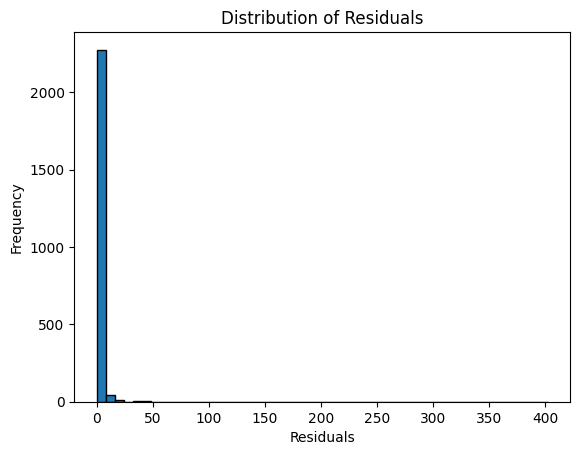

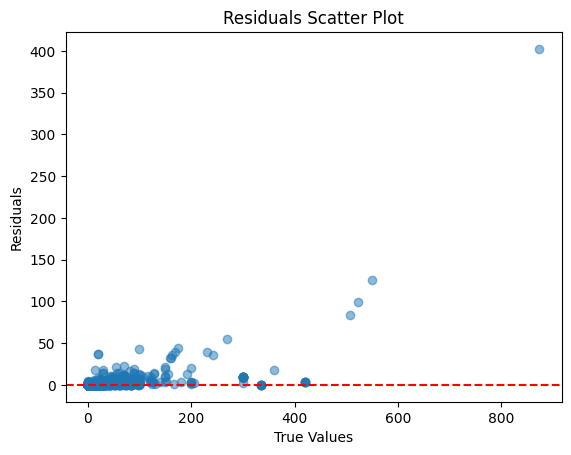

965    402.284027
Name: STACKS_COMPRATS, dtype: float64


In [54]:
# boxplot of the results
residuals = np.abs(preds-y_test)

# Create a histogram of residuals
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Alternatively, create a scatter plot
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Residuals Scatter Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

print(residuals[residuals>400])




In [58]:
# Check for outliers
print(preds[965])
print(y_test[965])
display(df_test.iloc[965])

CANTIDADCOMPRA               2619.000000
UNIDADESCONSUMOCONTENIDAS       3.000000
PRECIO                          0.989571
IMPORTELINEA                  863.895483
STACKS_COMPRATS               873.000000
                                ...     
DEPARTMENT_95                   0.000000
DEPARTMENT_96                   0.000000
DEPARTMENT_97                   0.000000
DEPARTMENT_98                   0.000000
DEPARTMENT_99                   0.000000
Name: 7014, Length: 339, dtype: float64

In [23]:
# Check for the grid search results
cv_results = grid_search.cv_results_
cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_subsample', 'param_reg_lambda', 'param_reg_alpha', 'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [24]:
cv_results['split0_test_score']

array([ -71.06260643,   -1.48169053,   -1.04355218,   -2.49338462,
         -2.35966534, -229.44346397,   -3.98889338,   -0.94846635,
         -3.15867935,   -3.74957348])

In [59]:
grid_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, nthread=10, num_parallel_tree=None,
             predictor=None, ...)

In [65]:
# save model
pickle.dump(grid_search, open('../models/xgboost_grid_all_years.pkl', 'wb'))